Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [X] Continue to participate in our Kaggle challenge.
- [X] Try Ordinal Encoding.
- [X] Try a Random Forest Classifier.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






In [850]:
# If you're in Colab...
'''import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')'''

"import os, sys\nin_colab = 'google.colab' in sys.modules\n\nif in_colab:\n    # Install required python packages:\n    # category_encoders, version >= 2.0\n    # pandas-profiling, version >= 2.0\n    # plotly, version >= 4.0\n    !pip install --upgrade category_encoders pandas-profiling plotly\n    \n    # Pull files from Github repo\n    os.chdir('/content')\n    !git init .\n    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git\n    !git pull origin master\n    \n    # Change into directory for module\n    os.chdir('module2')"

In [851]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [852]:
### Select features, scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2

### Wrangle function
def wrangle(df):
    """I heard you like docstrings"""
    import numpy as np
    
    # Copy the dataframe to itself so warnings can shsshshsh
    df = df.copy()
    # Thx for prelim work Ryan lol
    df['latitude'] = df['latitude'].replace(-2e-08,0)
    noZeroes = ['longitude','latitude','date_recorded','subvillage',
                'installer',
               ## BELOW
                ]
    for col in noZeroes:
        df[col] = df[col].replace(0,np.nan)
        df[col] = df[col].replace('0',np.nan)
        
    # Drop dupes
    df = df.drop(columns=['quantity_group','scheme_management',
                          'extraction_type_group','payment_type',
                          'quality_group','waterpoint_type_group'])
    
    # Make a date a date, and a year a year, bless.
    df['date_recorded'] = pd.to_datetime(df['date_recorded'],infer_datetime_format=True)
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day

    # YEEHAW dataframe return
    return df

### Reduce cardinality function for training and validation dataframesdef reduceCard(df1,df2,col,amt):
def reduceCard(df1,df2,col,amt):
    df1[col] = df1[col].astype(str)
    df2[col] = df2[col].astype(str)
    listoftop = df1[col].value_counts()[:amt].index
    df1.loc[~df1[col].isin(listoftop),col] = 'other'
    df2.loc[~df2[col].isin(listoftop),col] = 'other'
    return df1, df2

### Logistic Regression w/ One-hot encoder
lg = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    ## Imputer completes missing values
    #SimpleImputer(),
    IterativeImputer(),
    ## Scaler scales to unit variance, removing the mean(?)
    StandardScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=1000)
)

### Decision trees w/ One-hot Encoder
dt = make_pipeline(
    ## One hot encode
    ce.OneHotEncoder(use_cat_names=True),
    #SimpleImputer(),
    IterativeImputer(),
    DecisionTreeClassifier(min_samples_leaf=25,random_state=42)
)

### Random Forest w/ Ordinal Encoder
rf = make_pipeline(
    ce.OrdinalEncoder(),
    #ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    #IterativeImputer(max_iter=25),
    #SelectKBest(k=30),
    # n_estimators is # of trees in forest
    ## n_estimators=1020
    RandomForestClassifier(n_estimators=1020,random_state=4,n_jobs=-1)
)

### Gradient Booster
gb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier()
)

In [853]:
# Split data
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['status_group'],random_state=42)

In [854]:
# Assign variables
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [855]:
# Assign target -> 'status_group' & assign features
target = 'status_group'

# Numeric features
rid_of = train.drop(columns=['status_group','id','date_recorded',
                             'recorded_by','num_private','amount_tsh',
                            #ALL BELOW
                             ]).copy()
num_features = rid_of.select_dtypes(include='number').columns.tolist()

# Categorical features
cat_features = rid_of.select_dtypes(exclude='number').columns.tolist()
#'''
bad_bois = ['funder','ward','wpt_name','scheme_name',
            'subvillage','installer']
for i in bad_bois:
    ## 225
    train, val = reduceCard(train, val, i, 225)
#''';
features = num_features + cat_features

# Isolate columns from dataframes
X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test = test[features]

In [856]:
rf.fit(X_train,y_train)
rf.score(X_val,y_val)

0.8141414141414142

In [857]:
pd.options.display.max_columns = 500

train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_type,source_class,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded
43360,72938,0.0,2011-07-27,nan,0,nan,33.542898,-9.174777,other,0,Lake Nyasa,other,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,K,NaN,0,gravity,gravity,vwc,user-group,never pay,soft,insufficient,spring,spring,groundwater,communal standpipe,functional,2011,7,27
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,other,0,Rufiji,other,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,wua,user-group,pay monthly,soft,enough,spring,spring,groundwater,communal standpipe,functional,2011,3,23
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,other,0,Wami / Ruvu,other,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,nan,False,2010,india mark ii,handpump,vwc,user-group,pay per bucket,salty,insufficient,shallow well,shallow well,groundwater,hand pump,functional,2011,3,7
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,other,0,Lake Victoria,other,Kagera,18,1,Karagwe,other,0,True,GeoData Consultants Ltd,nan,True,0,other,other,vwc,user-group,never pay,soft,enough,shallow well,shallow well,groundwater,other,non functional,2011,7,31
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,other,0,Internal,other,Dodoma,1,6,Bahi,other,0,True,GeoData Consultants Ltd,other,True,0,mono,motorpump,vwc,user-group,pay per bucket,soft,enough,machine dbh,borehole,groundwater,communal standpipe,functional,2011,3,10


In [858]:
#'''
# Put predict on this
y_pred = rf.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('../../sub-01.csv', index=False)
#''';

In [859]:
import matplotlib.pyplot as plt
model = rf.named_steps['randomforestclassifier']

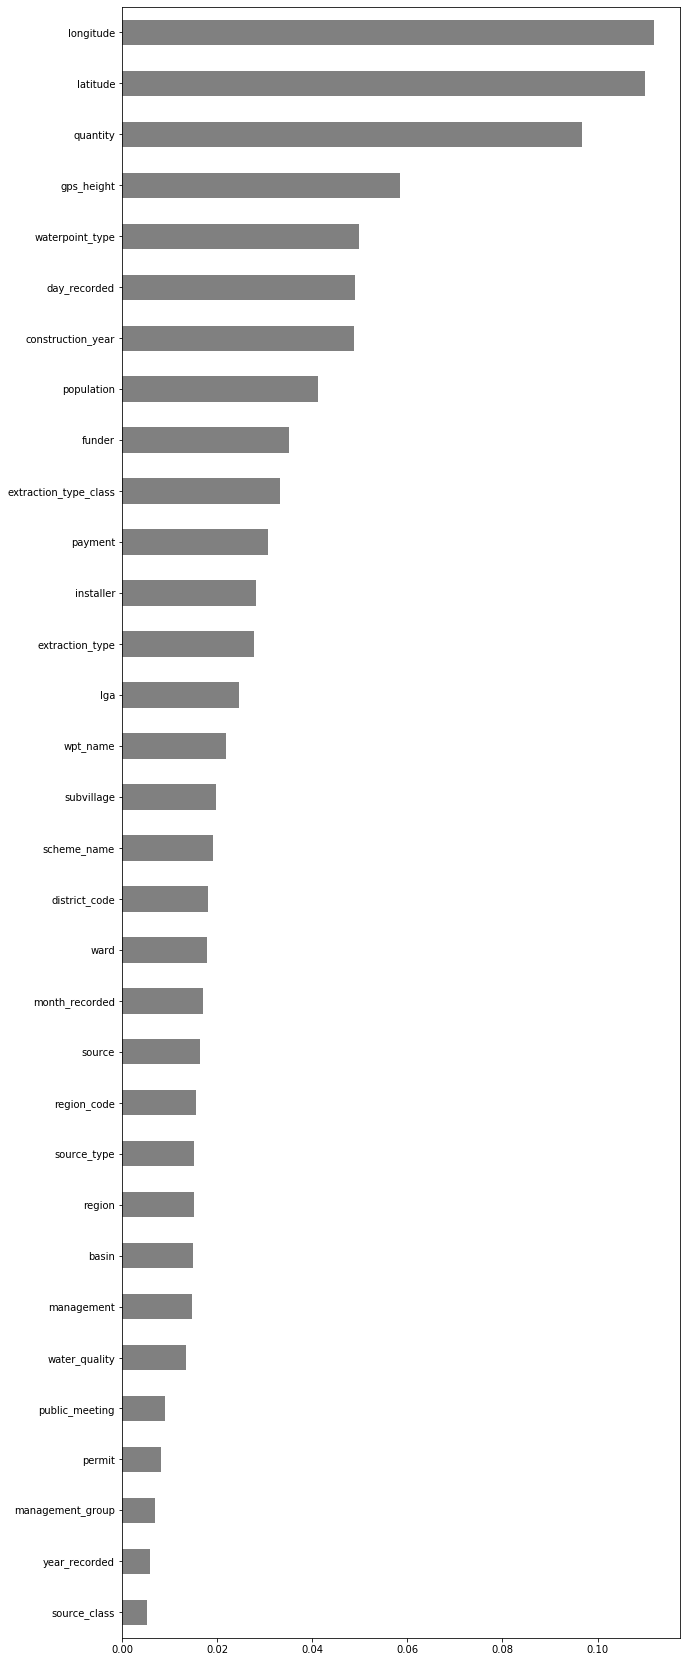

In [860]:
encoder = rf.named_steps['ordinalencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');